In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


# Pytorch入門
* https://github.com/yunjey/pytorch-tutorial

In [0]:
! git clone https://github.com/yunjey/pytorch-tutorial.git
% cd pytorch-tutorial/tutorials/PATH_TO_PROJECT
! python main.py

Cloning into 'pytorch-tutorial'...
remote: Enumerating objects: 910, done.
remote: Total 910 (delta 0), reused 0 (delta 0), pack-reused 910
Receiving objects: 100% (910/910), 12.80 MiB | 6.38 MiB/s, done.
Resolving deltas: 100% (486/486), done.
[Errno 2] No such file or directory: 'pytorch-tutorial/tutorials/PATH_TO_PROJECT'
/content
python3: can't open file 'main.py': [Errno 2] No such file or directory


# signate API設定とデータダウンロード

In [0]:
!pip install signate

     |████████████████████████████████| 133kB 5.6MB/s 
  Created wheel for wget: filename=wget-3.2-cp36-none-any.whl size=9682 sha256=38474ccdb4c6066215fc074092a02f759089da77f1e2749e7e5b0202c0d4dfa2
  Stored in directory: /root/.cache/pip/wheels/40/15/30/7d8f7cea2902b4db79e3fea550d7d7b85ecb27ef992b618f3f
Successfully built wget
ERROR: kaggle 1.5.6 has requirement urllib3<1.25,>=1.21.1, but you'll have urllib3 1.25.9 which is incompatible.
ERROR: datascience 0.10.6 has requirement folium==0.2.1, but you'll have folium 0.8.3 which is incompatible.
  Found existing installation: urllib3 1.24.3
    Uninstalling urllib3-1.24.3:
      Successfully uninstalled urllib3-1.24.3


In [0]:
! mkdir ~/.signate 
! cp "/content/drive/My Drive/signate.json" ~/.signate 

In [0]:
!signate --help

Usage: signate [OPTIONS] COMMAND [ARGS]...

Options:
  --version  Show the version and exit.
  --help     Show this message and exit.

Commands:
  download  Download the file of competition
  files     List file of competition
  list      List competition
  submit    Submit a result file to the...


In [0]:
! signate download -c 108

label_master.tsv

train_master.tsv

sample_submit.csv

test.zip

train.zip


Download completed.


In [0]:
%%bash
unzip train.zip
unzip test.zip

Archive:  train.zip
  inflating: train/train_00000.png   
  inflating: train/train_00001.png   
  inflating: train/train_00002.png   
  inflating: train/train_00003.png   
  inflating: train/train_00004.png   
  inflating: train/train_00005.png   
  inflating: train/train_00006.png   
  inflating: train/train_00007.png   
  inflating: train/train_00008.png   
  inflating: train/train_00009.png   
  inflating: train/train_00010.png   
  inflating: train/train_00011.png   
  inflating: train/train_00012.png   
  inflating: train/train_00013.png   
  inflating: train/train_00014.png   
  inflating: train/train_00015.png   
  inflating: train/train_00016.png   
  inflating: train/train_00017.png   
  inflating: train/train_00018.png   
  inflating: train/train_00019.png   
  inflating: train/train_00020.png   
  inflating: train/train_00021.png   
  inflating: train/train_00022.png   
  inflating: train/train_00023.png   
  inflating: train/train_00024.png   
  inflating: train/train_00025

# Pytorch 1.RESNET+fine_tuning

In [0]:
import copy
import os
import glob

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
%matplotlib inline

import dask.dataframe as dd
import pandas_profiling as pdp


#警告が鬱陶しい時はこれを記述
import warnings
warnings.filterwarnings('ignore')

#matplotlib 日本語化
import matplotlib.pyplot as plt
import matplotlib as mpl

mpl.font_manager._rebuild() #キャッシュの削除
plt.rcParams['font.family'] = 'IPAGothic' # インストールしたフォントを指定
pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 500)

from PIL import Image
from sklearn.model_selection import train_test_split

import torch #基本モジュール
from torch.autograd import Variable #自動微分用
import torch.nn as nn #ネットワーク構築用
import torch.optim as optim #最適化関数
import torch.nn.functional as F #ネットワーク用の様々な関数
import torch.utils.data #データセット読み込み関連
import torchvision #画像関連
from torchvision import datasets, models, transforms #画像用データセット諸々

SEED=1000

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [0]:
sample_submit = pd.read_csv('sample_submit.csv', header=None)
train_master = pd.read_table('train_master.tsv')
label_master = pd.read_table('label_master.tsv')
print(sample_submit.shape)
print(train_master.shape)
print(label_master.shape)

(10000, 21)
(50000, 2)
(20, 2)


In [0]:
sample_submit.head()

0         1         2         3         4         5         6   \
0  test_00000.png  0.036151  0.014607  0.034591  0.079934  0.053778  0.011690   
1  test_00001.png  0.033393  0.037818  0.021027  0.043661  0.082885  0.041105   
2  test_00002.png  0.098902  0.047091  0.022525  0.059422  0.038273  0.011877   
3  test_00003.png  0.054705  0.080344  0.047048  0.083701  0.043293  0.068830   
4  test_00004.png  0.087472  0.045188  0.091187  0.003265  0.110322  0.102048   

         7         8         9         10        11        12        13  \
0  0.039329  0.079885  0.047027  0.055246  0.062593  0.037947  0.080989   
1  0.069309  0.059735  0.023879  0.001008  0.077569  0.053666  0.044468   
2  0.086344  0.054882  0.046612  0.050381  0.028493  0.027183  0.092749   
3  0.026523  0.076391  0.008649  0.071797  0.020802  0.054486  0.065079   
4  0.048273  0.080005  0.050142  0.018821  0.096636  0.038774  0.050342   

         14        15        16        17        18        19        20  
0  0.066377  0.020849  0.057315  0.056351  0.033405  0.078505  0.053430  
1  0.040490  0.090077  0.050215  0.052718  0.067940  0.030642  0.078394  
2  0.076549  0.026914  0.099406  0.032409  0.038710  0.000611  0.060666  
3  0.060174  0.045692  0.052243  0.006735  0.036344  0.070731  0.026432  
4  0.044085  0.057429  0.023512  0.018324  0.002596  0.030469  0.001106

In [0]:
label_master.head(3)
label_master[label_master['label_id'] == 1]['label_name'].values[0]

'fish'

In [0]:
train_master.head()

file_name  label_id
0  train_00000.png        11
1  train_00001.png        15
2  train_00002.png         4
3  train_00003.png        14
4  train_00004.png         1

In [0]:
train_master.groupby(['label_id']).size()

label_id
0     2500
1     2500
2     2500
3     2500
4     2500
5     2500
6     2500
7     2500
8     2500
9     2500
10    2500
11    2500
12    2500
13    2500
14    2500
15    2500
16    2500
17    2500
18    2500
19    2500
dtype: int64

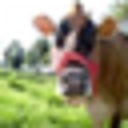

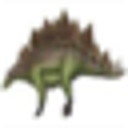

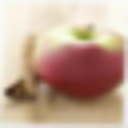

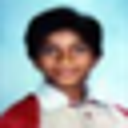

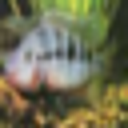

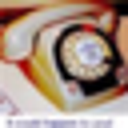

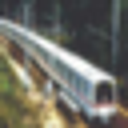

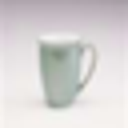

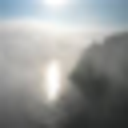

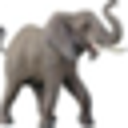

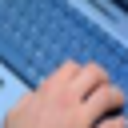

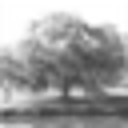

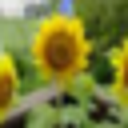

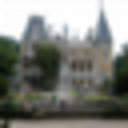

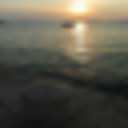

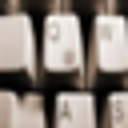

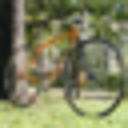

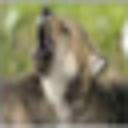

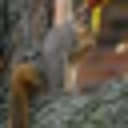

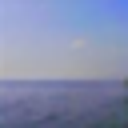

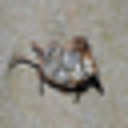

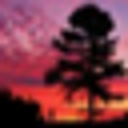

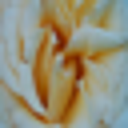

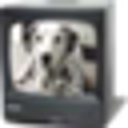

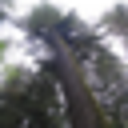

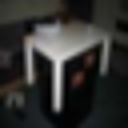

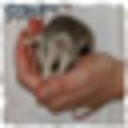

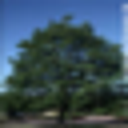

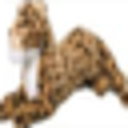

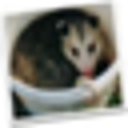

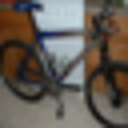

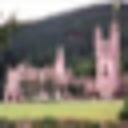

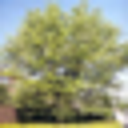

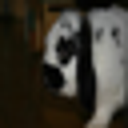

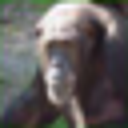

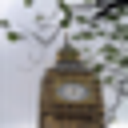

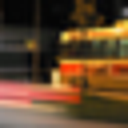

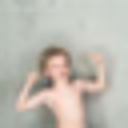

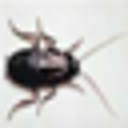

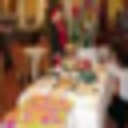

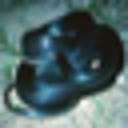

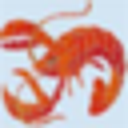

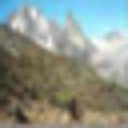

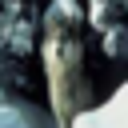

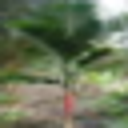

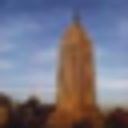

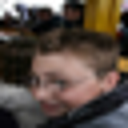

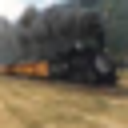

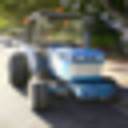

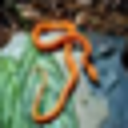

In [0]:
root_dir = '.'
img_paths = train_master['file_name'].apply(lambda x: os.path.join(root_dir, 'train', x))
for img in img_paths[:50]:
    im = Image.open(img)
    display(im.resize((128,128)))

## 学習データ,検証データ読み込みデータセット, データローダ定義

In [0]:
class MyDataset(torch.utils.data.Dataset):
    def __init__(self, img_paths, labels, transform=None, phase='train'):
        self.transform = transform
        self.img_paths = img_paths
        self.labels = labels
        self.phase = phase
    
    def __len__(self):
        return len(self.img_paths)

    
    def __getitem__(self, idx):        
        out_img = Image.open(self.img_paths[idx])
        out_label = self.labels[idx]
        if self.transform:
            out_img = self.transform(out_img, self.phase)

        return out_img, out_label


class ImageTransform():
    def __init__(self, resize):
        self.data_transform = {
            'train': transforms.Compose([
                transforms.Resize(resize),
                transforms.RandomAffine(degrees=20, scale=(0.8, 1.2), ),
                transforms.RandomHorizontalFlip(),
                transforms.ToTensor(),
                transforms.RandomErasing(p=0.5, scale=(0.02, 0.33), ratio=(0.3, 3.3)), # toTensor の後に入れないとエラーになる
                transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])]), #標準化
            'val': transforms.Compose([
                transforms.Resize(resize),
                transforms.ToTensor(),
                transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
                ]),
            'test': transforms.Compose([
                transforms.Resize(resize),
                transforms.ToTensor(),
                transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
            ])

        }

    
    def __call__(self, img, phase='train'):
        '''
        phase:で指定した変換モードで画像を変換する
        '''
        return self.data_transform[phase](img)

In [0]:
def create_dataset(img_paths, labels, transform):
    '''学習データと検証データに分割'''
    #all_dataset = MyDataset(img_paths, train_master['label_id'], transform=transform)

    #x_tr,x_val, y_tr, y_val = train_test_split(train_master['file_name'], train_master['label_id'], test_size=0.2, stratify=train_master['label_id'],random_state=SEED)
    x_tr,x_val, y_tr, y_val = train_test_split(img_paths, train_master['label_id'], test_size=0.2, stratify=train_master['label_id'],random_state=SEED)
    # print(x_tr, y_tr)
    # print(len(x_tr.index), len(x_val.index))

    tr_indices, val_indices = list(x_tr.index), list(x_val.index)
    # train_dataset = torch.utils.data.dataset.Subset(all_dataset, tr_indices)
    train_dataset = MyDataset(list(x_tr), list(y_tr), trans, phase='train')
    val_dataset = MyDataset(list(x_val), list(y_val), trans, phase='val')
    # val_dataset = torch.utils.data.dataset.Subset(all_dataset, val_indices)
    return train_dataset, val_dataset


size = 224
trans = ImageTransform(size)
train_dataset, val_dataset = create_dataset(img_paths, train_master['label_id'], trans)
dset_loaders = {
    'train':  torch.utils.data.DataLoader(train_dataset, batch_size=100, shuffle=True, num_workers=2),
    'val':  torch.utils.data.DataLoader(val_dataset, batch_size=100, shuffle=True, num_workers=2)
} 
#train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=100, shuffle=False, num_workers=2)
#valloader =  torch.utils.data.DataLoader(val_dataset, batch_size=100, shuffle=False, num_workers=2)

In [0]:
#print(len(train_dataset), len(val_dataset))
print(len(dset_loaders['val'].dataset))

10000


## ネットワーク定義

In [0]:
# Convolutional neural network (two convolutional layers)
class ConvNet(nn.Module):
    def __init__(self, num_classes=10):
        super(ConvNet, self).__init__()
        # nn.sequentialを用いると処理単位で一つの塊としてあつかえる。見通しが良くなる
        ## 使わなくてもいい。
        self.layer1 = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=2),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)) 
        self.layer2 = nn.Sequential(
            nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=2),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        self.fc = nn.Linear(2592, num_classes)
        
    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        #print(out.shape)
        #print(out.size(), out.size(0))
        out = out.reshape(out.size(0), -1)
        #out = out.view(-1, 20)
        #print(out.shape)
        out = self.fc(out)
        return out


class MyFCNet(nn.Module):
    def __init__(self, input_size, num_classes=10):
        super(MyFCNet, self).__init__()
        # nn.sequentialを用いると処理単位で一つの塊としてあつかえる。見通しが良くなる
        ## 使わなくてもいい。
        self.layer1 = nn.Sequential(
            nn.Linear(input_size, 2048, ),
            nn.BatchNorm1d(2048),
            nn.ReLU(),
            nn.Dropout(0.1))
        self.layer2 = nn.Sequential(
            nn.Linear(2048, 1024, ),
            nn.BatchNorm1d(1024),
            nn.ReLU(),
            nn.Dropout(0.1))
        self.fc = nn.Linear(1024, num_classes)
        #self.softmax = nn.Softmax()
        
    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        #print(out.shape)
        #print(out.size(), out.size(0))
        #out = out.reshape(out.size(0), -1)
        #out = out.view(-1, 20)
        #print(out.shape)
        out = self.fc(out)
        #out = self.softmax(out)
        return out


def set_parameter_requires_grad(model, feature_extracting, update_layers=[]):
    '''学習するレイヤを設定する'''
    if feature_extracting:
        for param in model.parameters():
            param.requires_grad = False
    else:    #print(model.parameters())
        for name, param in model.named_parameters():
            #print(name)
            if name in update_layers:
                param.requires_grad = True
            else:
                param.requires_grad = False


def resnet_finetune(num_classes, update_layers=[]):
    #resnetからのモデルの読み込み
    model_ft = models.resnet18(pretrained=True)

    # 勾配を更新するレイヤ設定
    set_parameter_requires_grad(model_ft, False, update_layers)

    #最終のfc層を置き換え
    num_ftrs = model_ft.fc.in_features
    #model_ft.fc = nn.Linear(num_ftrs, num_classes)
    model_ft.fc = MyFCNet(num_ftrs, num_classes)
    return model_ft


## 学習

In [0]:
class EarlyStopping:
    """
    Stolen from https://github.com/Bjarten/early-stopping-pytorch
    Early stops the training if validation loss doesn't improve after a given patience.
    """
    def __init__(self, patience=7, verbose=False):
        """
        Args:
            patience (int): How long to wait after last time validation loss improved.
                            Default: 7
            verbose (bool): If True, prints a message for each validation loss improvement. 
                            Default: False
        """
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf

    def __call__(self, val_loss, model):

        score = -val_loss
        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score:
            self.counter += 1
            print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        '''Saves model when validation loss decrease.'''
        if self.verbose:
            print(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model ...')
        torch.save(model.state_dict(), 'checkpoint.pt')
        self.val_loss_min = val_loss


# learning rateのスケジューラの設定
def exp_lr_scheduler(optimizer, epoch, init_lr=0.001, lr_decay_epoch=7):
    """Decay learning rate by a factor of 0.1 every lr_decay_epoch epochs."""
    lr = init_lr * (0.1**(epoch // lr_decay_epoch))

    if epoch % lr_decay_epoch == 0:
        print('LR is set to {}'.format(lr))

    for param_group in optimizer.param_groups:
        param_group['lr'] = lr

    return optimizer



In [0]:
# 学習
from tqdm import tqdm
import time

def train_model(model, dset_loaders, criterion, optimizer, lr_scheduler, num_epochs=25):
    '''
    dset_loaders dict: key:'train',or'val', value: train_loader or val_loader
    '''
    since = time.time()

    best_model = model
    best_acc = 0.0
    best_loss = 99999999
    
    # Device configuration
    device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

    # early stopping
    early_stopping = EarlyStopping(patience=5, verbose=True)

    for epoch in range(num_epochs):
        #開始エポックの表示
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # トレーニングかテストかの指定
        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                #optimizerのスケジューラの設定
                optimizer = lr_scheduler(optimizer, epoch)
                model.train(True)  # Set model to training mode
            else:
                model.train(False)  # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dset_loaders[phase]:
                # get the inputs
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                outputs = model(inputs)
                _, preds = torch.max(outputs.data, 1)
                loss = criterion(outputs, labels)

                # backward + optimize only if in training phase
                if phase == 'train':
                    loss.backward()
                    optimizer.step()

                # statistics
                #print(loss.data)
                running_loss += loss.data
                running_corrects += torch.sum(preds == labels.data)
                
            #print(len(dset_loaders[phase]))
            #print(running_loss, dset_sizes[phase])
            #print(running_corrects)
            epoch_loss = running_loss.item() /  len(dset_loaders[phase].dataset)
            epoch_acc = running_corrects.item() / len(dset_loaders[phase].dataset)

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))
            
            if phase == 'val':
                early_stopping(epoch_loss, model)  
                # 前より良くなってた時のみモデル更新をする
                # deep copy the model
                if epoch_loss < best_loss:
                    best_acc = epoch_acc
                    best_loss = epoch_loss
                    best_model = copy.deepcopy(model)

        if early_stopping.early_stop:
            print("Early stopping")
            break
        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Loss: {:4f}'.format(best_loss))
    print('Best val Acc: {:4f}'.format(best_acc))
    return best_model

In [0]:
# device
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
#model = ConvNet(num_classes=20).to(device)
update_layers = [
'layer4.0.conv1.weight',
'layer4.0.bn1.weight',
'layer4.0.bn1.bias',
'layer4.0.conv2.weight',
'layer4.0.bn2.weight',
'layer4.0.bn2.bias',
'layer4.0.downsample.0.weight',
'layer4.0.downsample.1.weight',
'layer4.0.downsample.1.bias',
'layer4.1.conv1.weight',
'layer4.1.bn1.weight',
'layer4.1.bn1.bias',
'layer4.1.conv2.weight',
'layer4.1.bn2.weight',
'layer4.1.bn2.bias',
'fc.weight',
'fc.bias',
]
model = resnet_finetune(num_classes=20, update_layers=update_layers).to(device)
criterion = nn.CrossEntropyLoss()
learning_rate = 0.1
num_epochs=50
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [0]:
best_model = train_model(model, dset_loaders, criterion, optimizer, exp_lr_scheduler, num_epochs)

Epoch 0/49
----------
LR is set to 0.001
train Loss: 0.0146 Acc: 0.5363
val Loss: 0.0115 Acc: 0.6324
Validation loss decreased (inf --> 0.011528).  Saving model ...

Epoch 1/49
----------
train Loss: 0.0113 Acc: 0.6376
val Loss: 0.0088 Acc: 0.7215
Validation loss decreased (0.011528 --> 0.008847).  Saving model ...

Epoch 2/49
----------
train Loss: 0.0100 Acc: 0.6823
val Loss: 0.0077 Acc: 0.7545
Validation loss decreased (0.008847 --> 0.007674).  Saving model ...

Epoch 3/49
----------
train Loss: 0.0092 Acc: 0.7062
val Loss: 0.0074 Acc: 0.7629
Validation loss decreased (0.007674 --> 0.007439).  Saving model ...

Epoch 4/49
----------
train Loss: 0.0085 Acc: 0.7272
val Loss: 0.0068 Acc: 0.7870
Validation loss decreased (0.007439 --> 0.006792).  Saving model ...

Epoch 5/49
----------
train Loss: 0.0081 Acc: 0.7397
val Loss: 0.0070 Acc: 0.7765
EarlyStopping counter: 1 out of 5

Epoch 6/49
----------
train Loss: 0.0076 Acc: 0.7554
val Loss: 0.0065 Acc: 0.7954
Validation loss decreased (

KeyboardInterrupt: ignored

# 予測

In [0]:
! cp /content/checkpoint.pt '/content/drive/My Drive/Colab Notebooks'
#!cp '/content/drive/My Drive/Colab Notebooks/checkpoint.pt' /content/checkpoint.pt 

In [0]:
def load_model(path):
    model = resnet_finetune(num_classes=20, update_layers=update_layers).to(device)
    model.load_state_dict(torch.load(path))
    model = model.eval()
    return model.to(device)

#予測と画像の表示
def visualize_model(model, dset_loader, num_images=6, use_gpu=False):
    images_so_far = 0
    fig = plt.figure()

    # 標準imageを元に戻す
    invTrans = transforms.Compose([ transforms.Normalize(mean = [ 0., 0., 0. ],
                                                        std = [ 1/0.229, 1/0.224, 1/0.225 ]),
                                    transforms.Normalize(mean = [ -0.485, -0.456, -0.406 ],
                                                        std = [ 1., 1., 1. ]),
                                ])
    
    for i, data in enumerate(dset_loader):
        inputs, labels = data
        if use_gpu:
            inputs, labels = Variable(inputs.cuda()), Variable(labels.cuda())
        else:
            inputs, labels = Variable(inputs), Variable(labels)

        #予測
        outputs = model(inputs)
        pred += [int(l.argmax()) for l in output]

        _, preds = torch.max(outputs.data, 1)

        for j in range(inputs.size()[0]):
            images_so_far += 1
            #print(labels.data[j])
            pred_class = label_master[label_master['label_id'] == labels.data[j].item()]['label_name'].values[0]
            #print(pred_class)
            print(invTrans(inputs.data[j]).detach().cpu().numpy().transpose([1,2,0]))
            # ax.set_title('predicted: {}'.format(pred_class))
            plt.imshow(invTrans(inputs.data[j]).
                       detach().cpu().numpy().transpose([1,2,0]))
            plt.show()

#            plt.imshow(inputs.cpu().data[j].detach().numpy().transpose([1,2,0]), ax)
            if images_so_far == num_images:
                return

model = load_model('/content/checkpoint.pt')


In [0]:
test_paths = [f'./test/{name}' for name in sample_submit.iloc[:,0]]
test_dataset = MyDataset(test_paths, list(sample_submit.iloc[:, 0]), trans, phase='test')
#test_loader = torch.utils.data.DataLoader(test, batch_size=BATCH_SIZE, shuffle=False)
test_loader =  torch.utils.data.DataLoader(test_dataset, batch_size=100, shuffle=False, num_workers=2)
preds = []
for images, names in test_loader:
    if torch.cuda.is_available():
        images = Variable(images.cuda())
    else:
        images = Variable(images)
    #print(type(images))
    #print(names[0])
    with torch.no_grad():
        output = model(images)
        sm = torch.nn.Softmax() #ネットワーク外でsoftmaxする
        probabilities = sm(output) 

    for name, proba in zip(names, probabilities):
        l = [name] + proba.cpu().detach().numpy().tolist()
        #print(l)
        preds.append(l)
    #pred += [int(l.argmax()) for l in output]
    #print(pred)

In [0]:
submission = pd.DataFrame(preds)
submission.head(3)

0         1         2             3         4             5  \
0  test_00000.png  0.025308  0.000316  6.517253e-06  0.000009  5.045721e-07   
1  test_00001.png  0.000005  0.000003  1.133942e-06  0.000182  4.900204e-06   
2  test_00002.png  0.973683  0.000615  5.057684e-09  0.000001  2.102247e-07   

              6             7             8         9            10        11  \
0  2.892515e-04  2.165800e-05  1.925999e-04  0.000059  1.666093e-01  0.177853   
1  2.145139e-05  2.252505e-04  9.433618e-07  0.000213  9.920951e-04  0.987388   
2  6.306494e-08  1.881582e-08  5.836688e-06  0.000045  3.108988e-07  0.000007   

         12        13        14        15        16        17            18  \
0  0.000133  0.000073  0.001211  0.001365  0.001982  0.000017  5.559324e-03   
1  0.000300  0.000023  0.000045  0.001758  0.000015  0.000058  8.087601e-03   
2  0.000014  0.000004  0.000014  0.000002  0.025591  0.000016  1.910721e-07   

             19        20  
0  6.078188e-01  0.011176  
1  3.008471e-05  0.000646  
2  5.301413e-07  0.000002

In [0]:
submission.to_csv('subission.csv', index=False, header=False)

In [0]:
# 提出
!signate submit --competition-id=108 /content/subission.csv

You have successfully submitted your predictions.We will send you the submission result to your email address.


In [0]:
#label_master
sample_submit.head(3)

test_00000.png  0.03615144545058148  0.014606614480129778  \
0  test_00001.png             0.033393              0.037818   
1  test_00002.png             0.098902              0.047091   
2  test_00003.png             0.054705              0.080344   

   0.03459058905468106  0.07993426720755435  0.05377840973329023  \
0             0.021027             0.043661             0.082885   
1             0.022525             0.059422             0.038273   
2             0.047048             0.083701             0.043293   

   0.0116903831232342  0.0393292930239412  0.07988545469352425  \
0            0.041105            0.069309             0.059735   
1            0.011877            0.086344             0.054882   
2            0.068830            0.026523             0.076391   

   0.047027483009391934  0.055245544806695836  0.06259332479593792  \
0              0.023879              0.001008             0.077569   
1              0.046612              0.050381             0.028493   
2              0.008649              0.071797             0.020802   

   0.03794687388775113  0.08098908665165408  0.06637683327991949  \
0             0.053666             0.044468             0.040490   
1             0.027183             0.092749             0.076549   
2             0.054486             0.065079             0.060174   

   0.02084850473578837  0.05731462505832309  0.0563509884244787  \
0             0.090077             0.050215            0.052718   
1             0.026914             0.099406            0.032409   
2             0.045692             0.052243            0.006735   

   0.03340536360620035  0.07850479662189785  0.05343011835502462  
0             0.067940             0.030642             0.078394  
1             0.038710             0.000611             0.060666  
2             0.036344             0.070731             0.026432

In [0]:
visualize_model(model, test_loader, num_images=1, use_gpu=torch.cuda.is_available())

ValueError: ignored

In [0]:
from torchsummary import summary
summary(model, (3,224,224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]          36,864
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
       BasicBlock-11           [-1, 64, 56, 56]               0
           Conv2d-12           [-1, 64, 56, 56]          36,864
      BatchNorm2d-13           [-1, 64, 56, 56]             128
             ReLU-14           [-1, 64,